# Airbnb Data for New York
### 3 Things You Should Know Before Booking an Airbnb in New York

1. What factors influence the price of an Airbnb rental?
2. What are the most expensive / least expensive neighborhoods to book and Airbnb?
3. What time of year is best to book an Airbnb?

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import json
import datetime
from pprint import pprint
import seaborn as sns

%matplotlib inline

## Step 0: Import & Assess Data

In [2]:
# Load in csv files
calendar_df = pd.read_csv('calendar.csv')
listings_df = pd.read_csv('listings_detailed.csv')
neighborhoods_df = pd.read_csv('neighbourhoods.csv')
reviews_df = pd.read_csv('reviews_detailed.csv')

C:\Users\giust\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Load in JSON file
with open('neighbourhoods.geojson') as f:
    neighborhoods_geo = json.load(f)

#### calendar_df

Detailed Calendar Data for listings in New York City

In [4]:
calendar_df.head()

,listing_id,date,available,price
0,14314,2019-09-07,t,$154.00
1,14314,2019-09-06,t,$154.00
2,14314,2019-09-05,t,$144.00
3,14314,2019-09-04,t,$144.00
4,14314,2019-09-03,t,$144.00


In [5]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18330300 entries, 0 to 18330299
Data columns (total 4 columns):
listing_id    int64
date          object
available     object
price         object
dtypes: int64(1), object(3)
memory usage: 559.4+ MB


In [6]:
calendar_df['available'].value_counts()

f    12549361
t     5780939
Name: available, dtype: int64

> **calendar_df - To Clean**
- **date** - change type to datetime
- **available** - update type to boolean True/False
- **price** - change type to float

#### listings_df

Detailed Listings data for New York City

In [7]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20180908060534,2018-09-08,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,1.41
1,2539,https://www.airbnb.com/rooms/2539,20180908060534,2018-09-08,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,NaN,NaN,f,f,moderate,f,f,8,0.24
2,2595,https://www.airbnb.com/rooms/2595,20180908060534,2018-09-08,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,2,0.32
3,3330,https://www.airbnb.com/rooms/3330,20180908060534,2018-09-08,++ Brooklyn Penthouse Guestroom ++,"This is a spacious, clean, furnished master be...","Room Features: - clean, hardwood floors - 2 la...","This is a spacious, clean, furnished master be...",none,Location is GREAT!! Right off the L train in t...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,3,0.31
4,3647,https://www.airbnb.com/rooms/3647,20180908060534,2018-09-08,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,t,t,1,NaN


In [8]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50220 entries, 0 to 50219
Data columns (total 96 columns):
id                                  50220 non-null int64
listing_url                         50220 non-null object
scrape_id                           50220 non-null int64
last_scraped                        50220 non-null object
name                                50195 non-null object
summary                             48360 non-null object
space                               34428 non-null object
description                         49793 non-null object
experiences_offered                 50220 non-null object
neighborhood_overview               29795 non-null object
notes                               19830 non-null object
transit                             31136 non-null object
access                              29056 non-null object
interaction                         27817 non-null object
house_rules                         29928 non-null object
thumbnail_url          

In [9]:
# Review % NaN for each field
listings_nan_df = pd.DataFrame((listings_df.isnull().sum() / listings_df.shape[0])).reset_index().sort_values(by=0,ascending=False)
listings_nan_df = listings_nan_df.rename(columns={'index': 'feature', 0: '%_nan'})
listings_nan_df.head()

,feature,%_nan
15,thumbnail_url,1.000000
27,host_acceptance_rate,1.000000
18,xl_picture_url,1.000000
16,medium_url,1.000000
87,license,0.999861


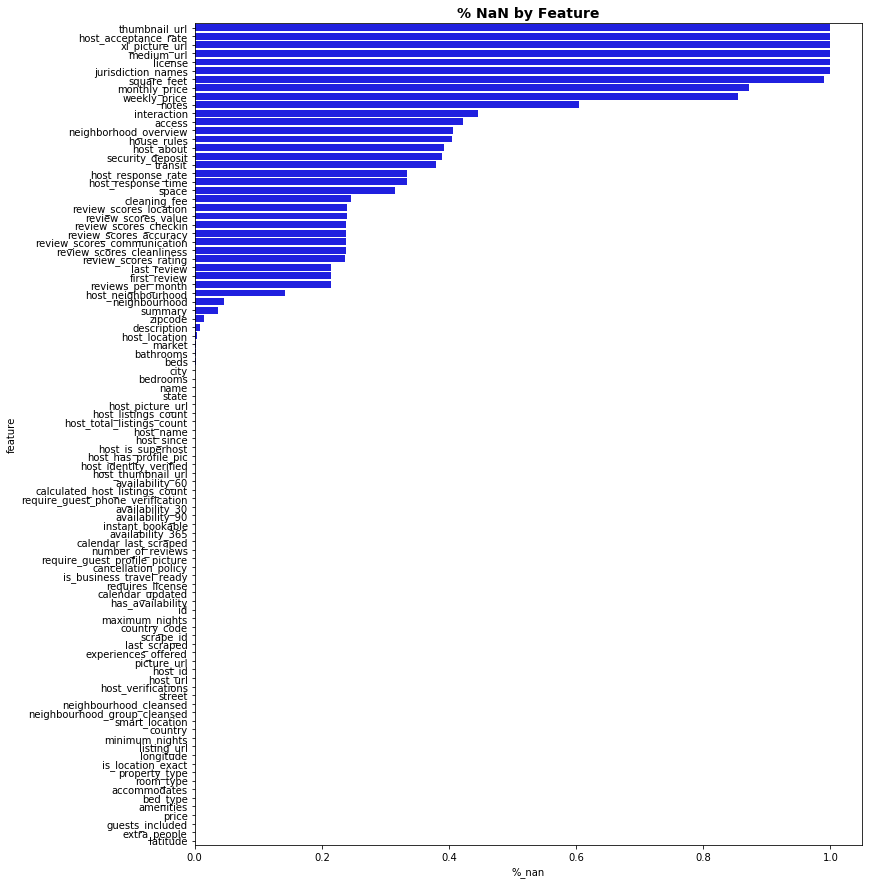

In [10]:
fig, ax = plt.subplots(figsize=(10,12))
plt.tight_layout()

sns.barplot(listings_nan_df['%_nan'], listings_nan_df['feature'], color='b', )
ax.set_title('% NaN by Feature', fontsize=14, weight='bold');

In [11]:
listings_df[list(listings_nan_df['feature'])[10:35]].head()

,interaction,access,neighborhood_overview,house_rules,host_about,security_deposit,transit,host_response_rate,host_response_time,space,...,review_scores_communication,review_scores_cleanliness,review_scores_rating,last_review,first_review,reviews_per_month,host_neighbourhood,neighbourhood,summary,zipcode
0,We will have a list of Harlem restaurants and ...,Guests will have their PRIVATE BATHROOM (NOTE:...,NaN,no-smoking/please take off your shoes: cleanin...,loves to host and welcome travelers from arou...,$0.00,Subway 2.3.B.C. at 110th street around the cor...,93%,within a few hours,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,...,9.0,9.0,93.0,2018-07-05,2008-10-13,1.41,Harlem,Harlem,Step into our artistic spacious apartment and ...,10026
1,NaN,NaN,Close to Prospect Park and Historic Ditmas Park,-The security and comfort of all our guests is...,Educated professional living in Brooklyn. I l...,$100.00,Very close to F and G trains and Express bus i...,100%,within an hour,"Spacious, renovated, and clean apt home, one b...",...,10.0,10.0,98.0,2018-07-17,2015-12-04,0.24,Gravesend,Kensington,Renovated apt home in elevator building.,11218
2,I am a Sound Therapy Practitioner and Kundalin...,"Guests have full access to the kitchen, bathro...",Centrally located in the heart of Manhattan ju...,"Make yourself at home, respect the space and t...",A New Yorker since 2000! My passion is creatin...,$350.00,Apartment is located on 37th Street between 5t...,79%,within a day,"- Spacious (500+ft²), immaculate and nicely fu...",...,10.0,9.0,94.0,2018-06-29,2009-11-21,0.32,Midtown,Midtown,"Find your romantic getaway to this beautiful, ...",10018
3,I will likely not be around as my room (Pentho...,The apartment is equipped with full kitchen (m...,Location is GREAT!! Right off the L train in t...,Guests should be respectful of the home and th...,From Brooklyn with love.,$150.00,You will be STEPS AWAY FROM THE L TRAIN. Hop o...,100%,within a day,"Room Features: - clean, hardwood floors - 2 la...",...,10.0,10.0,97.0,2018-06-15,2010-01-04,0.31,East Williamsburg,Williamsburg,"This is a spacious, clean, furnished master be...",11206
4,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,Make Up Artist National/ (Website hidden by Ai...,$200.00,NaN,NaN,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,...,NaN,NaN,NaN,NaN,NaN,NaN,Harlem,Harlem,NaN,10027


In [12]:
# Check for duplicated IDs
listings_df['id'].duplicated().sum()

0

In [13]:
# Check for IDs listed in calendar_df but not in listings_df
calendar_df[~calendar_df['listing_id'].isin(listings_df['id'])]

,listing_id,date,available,price


In [14]:
# Check for IDs listed in listings_df but not in calendar_df
listings_df[~listings_df['id'].isin(calendar_df['listing_id'])]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month


>**listings_df - To Clean**
- **Drop the folowing fields**
    - Any fields with > 50% NaN values
- **Drop the folowing rows** 
    - Any rows with > 30% NaN values
- **price** - change type to float
- **security_deposit** - change type to float
- **cleaning_fee** - change type to float

#### review_df

Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).

In [15]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2515,198,2008-10-13,2603,Jenny,Stephanie was a wonderful host! Her apartment ...
1,2515,859,2009-03-08,8455,Roland,Such a wonderful place and very close to the m...
2,2515,1083,2009-03-25,9759,Cem,I just got back from a trip to NYC during whic...
3,2515,1107,2009-03-27,9193,Holly,Stephanie's offered all the most important thi...
4,2515,2175,2009-05-09,7048,Alessandra,"Stephanie was really nice, ftiendly and helpfu..."


In [16]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030208 entries, 0 to 1030207
Data columns (total 6 columns):
listing_id       1030208 non-null int64
id               1030208 non-null int64
date             1030208 non-null object
reviewer_id      1030208 non-null int64
reviewer_name    1030208 non-null object
comments         1029027 non-null object
dtypes: int64(3), object(3)
memory usage: 47.2+ MB


> **reviews_df - To Clean**
- **date** - change type to datetime
- **comments** - drop rows with missing comments

#### neighborhoods_df

Neighbourhood list for geo filter. Sourced from city or open source GIS files.

In [17]:
neighborhoods_df.head()

,neighbourhood_group,neighbourhood
0,Bronx,Allerton
1,Bronx,Baychester
2,Bronx,Belmont
3,Bronx,Bronxdale
4,Bronx,Castle Hill


In [18]:
neighborhoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 2 columns):
neighbourhood_group    230 non-null object
neighbourhood          230 non-null object
dtypes: object(2)
memory usage: 3.7+ KB


> **neighborhoods_df - To Clean**
- Merge coordinates from `neighborhoods_geo` to this df

#### neighborhoods_geo

GeoJSON file of neighbourhoods of the city.

In [19]:
pprint(neighborhoods_geo)

{'features': [{'geometry': {'coordinates': [[[[-73.766708, 40.614911],
                                              [-73.768253, 40.614878],
                                              [-73.773977, 40.616004],
                                              [-73.773631, 40.616327],
                                              [-73.768735, 40.620901],
                                              [-73.767459, 40.620511],
                                              [-73.766978, 40.616919],
                                              [-73.766708, 40.614911]]]],
                            'type': 'MultiPolygon'},
               'properties': {'neighbourhood': 'Bayswater',
                              'neighbourhood_group': 'Queens'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [[[[-73.848597, 40.87167],
                                              [-73.845823, 40.870239],
                                              [-73.854559, 40.859954],
     

                                              [-73.792375, 40.856906],
                                              [-73.792428, 40.856929],
                                              [-73.792267, 40.857133],
                                              [-73.792245, 40.857123],
                                              [-73.792222, 40.857152],
                                              [-73.792827, 40.857436],
                                              [-73.792954, 40.856992],
                                              [-73.793013, 40.857003],
                                              [-73.792884, 40.857479],
                                              [-73.792811, 40.857464],
                                              [-73.79186, 40.857004],
                                              [-73.791854, 40.857014],
                                              [-73.792683, 40.85742],
                                              [-73.792609, 40.857508],
        

                                              [-73.820981, 40.800478],
                                              [-73.820855, 40.800538],
                                              [-73.820786, 40.80056],
                                              [-73.820432, 40.800628],
                                              [-73.820528, 40.801006],
                                              [-73.820499, 40.801011],
                                              [-73.820405, 40.80064],
                                              [-73.820262, 40.800709],
                                              [-73.820129, 40.800765],
                                              [-73.820081, 40.800802],
                                              [-73.820058, 40.800816],
                                              [-73.820007, 40.800835],
                                              [-73.819953, 40.800849],
                                              [-73.81991, 40.800886],
         

              {'geometry': {'coordinates': [[[[-74.014752, 40.633967],
                                              [-74.014753, 40.633966],
                                              [-74.021216, 40.618472],
                                              [-74.02835, 40.622799],
                                              [-74.041652, 40.626018],
                                              [-74.041273, 40.628703],
                                              [-74.041063, 40.63019],
                                              [-74.03829, 40.635919],
                                              [-74.036807, 40.638984],
                                              [-74.038763, 40.639588],
                                              [-74.038688, 40.639738],
                                              [-74.036725, 40.639141],
                                              [-74.036344, 40.639798],
                                              [-74.035993, 40.639694],
         

               'properties': {'neighbourhood': 'Bath Beach',
                              'neighbourhood_group': 'Brooklyn'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [[[[-73.745663, 40.751578],
                                              [-73.744103, 40.748186],
                                              [-73.743763, 40.747559],
                                              [-73.74648, 40.746846],
                                              [-73.744765, 40.743332],
                                              [-73.745735, 40.74295],
                                              [-73.748443, 40.743341],
                                              [-73.753493, 40.742388],
                                              [-73.751452, 40.740234],
                                              [-73.749903, 40.739766],
                                              [-73.744016, 40.740775],
                                              [-73.743714, 

                                              [-73.967203, 40.573326],
                                              [-73.96739, 40.573259],
                                              [-73.967436, 40.573209],
                                              [-73.967436, 40.573206],
                                              [-73.967364, 40.573045],
                                              [-73.967395, 40.572995],
                                              [-73.967426, 40.572985],
                                              [-73.967449, 40.573008],
                                              [-73.967531, 40.573191],
                                              [-73.968185, 40.573178],
                                              [-73.968849, 40.573058],
                                              [-73.969451, 40.572857],
                                              [-73.969212, 40.572335],
                                              [-73.969246, 40.572304],
       

              {'geometry': {'coordinates': [[[[-73.855315, 40.814412],
                                              [-73.85538, 40.814289],
                                              [-73.855848, 40.815797],
                                              [-73.855517, 40.815833],
                                              [-73.856197, 40.817917],
                                              [-73.857202, 40.822155],
                                              [-73.842898, 40.824083],
                                              [-73.843585, 40.827003],
                                              [-73.842317, 40.827185],
                                              [-73.842206, 40.82687],
                                              [-73.842027, 40.826547],
                                              [-73.840868, 40.824154],
                                              [-73.84045, 40.823346],
                                              [-73.84042, 40.823269],
          

                                              [-73.849739, 40.78004],
                                              [-73.84974, 40.78004],
                                              [-73.850315, 40.780032],
                                              [-73.850315, 40.780042],
                                              [-73.850374, 40.780035],
                                              [-73.850376, 40.78001],
                                              [-73.850416, 40.780011],
                                              [-73.850418, 40.780035],
                                              [-73.85045, 40.780034],
                                              [-73.850457, 40.779888],
                                              [-73.850482, 40.779888],
                                              [-73.850484, 40.779962],
                                              [-73.851623, 40.779939],
                                              [-73.851636, 40.779869],
           

                                              [-73.814471, 40.839621],
                                              [-73.814384, 40.839635],
                                              [-73.814387, 40.839643],
                                              [-73.814316, 40.83965],
                                              [-73.814309, 40.839622],
                                              [-73.814385, 40.839613],
                                              [-73.814387, 40.839623],
                                              [-73.814471, 40.839612],
                                              [-73.81447, 40.839606],
                                              [-73.81472, 40.839572],
                                              [-73.814697, 40.839451],
                                              [-73.814783, 40.839076],
                                              [-73.815426, 40.838783],
                                              [-73.815965, 40.838573],
         

                                              [-73.783293, 40.60393],
                                              [-73.783326, 40.603932],
                                              [-73.78335, 40.603948],
                                              [-73.783391, 40.603972],
                                              [-73.783455, 40.60402],
                                              [-73.783481, 40.604048],
                                              [-73.783891, 40.604697],
                                              [-73.783924, 40.604777],
                                              [-73.783948, 40.604824],
                                              [-73.783957, 40.604865],
                                              [-73.783932, 40.604925],
                                              [-73.7839, 40.60496],
                                              [-73.783808, 40.605074],
                                              [-73.783667, 40.605324],
            

              {'geometry': {'coordinates': [[[[-73.750236, 40.685649],
                                              [-73.740806, 40.682769],
                                              [-73.740365, 40.68344],
                                              [-73.73562, 40.681871],
                                              [-73.733646, 40.685542],
                                              [-73.727183, 40.683597],
                                              [-73.728102, 40.681766],
                                              [-73.729506, 40.680056],
                                              [-73.730527, 40.679364],
                                              [-73.731874, 40.677569],
                                              [-73.733283, 40.676145],
                                              [-73.736011, 40.67261],
                                              [-73.736249, 40.672631],
                                              [-73.737242, 40.670956],
         

                                              [-74.159395, 40.527428],
                                              [-74.159701, 40.527296],
                                              [-74.159876, 40.527371],
                                              [-74.159944, 40.527365],
                                              [-74.160011, 40.527343],
                                              [-74.160056, 40.527345],
                                              [-74.160084, 40.527361],
                                              [-74.160226, 40.527524],
                                              [-74.160265, 40.527553],
                                              [-74.160341, 40.52755],
                                              [-74.161527, 40.527029],
                                              [-74.161582, 40.527013],
                                              [-74.161691, 40.527024],
                                              [-74.162272, 40.527194],
       

               'properties': {'neighbourhood': 'Howland Hook',
                              'neighbourhood_group': 'Staten Island'},
               'type': 'Feature'},
              {'geometry': {'coordinates': [[[[-73.829119, 40.861587],
                                              [-73.828015, 40.860703],
                                              [-73.827098, 40.859073],
                                              [-73.830092, 40.858151],
                                              [-73.836463, 40.856192],
                                              [-73.843753, 40.857185],
                                              [-73.846551, 40.857524],
                                              [-73.849335, 40.857587],
                                              [-73.857112, 40.857036],
                                              [-73.856389, 40.857594],
                                              [-73.854665, 40.859586],
                                              [-73

                                              [-73.723059, 40.766144],
                                              [-73.722484, 40.765527],
                                              [-73.722484, 40.765527],
                                              [-73.722482, 40.765526],
                                              [-73.721143, 40.764873],
                                              [-73.720975, 40.764763],
                                              [-73.720809, 40.764648],
                                              [-73.713012, 40.759556],
                                              [-73.714804, 40.759649],
                                              [-73.716499, 40.759448],
                                              [-73.717975, 40.759027],
                                              [-73.71916, 40.758484],
                                              [-73.719326, 40.758375],
                                              [-73.719581, 40.758208],
       

                                              [-74.156115, 40.637531],
                                              [-74.155699, 40.637518],
                                              [-74.155685, 40.637787],
                                              [-74.155618, 40.63847],
                                              [-74.155493, 40.638467],
                                              [-74.155553, 40.637784],
                                              [-74.155589, 40.637786],
                                              [-74.155586, 40.637731],
                                              [-74.154829, 40.637724],
                                              [-74.154759, 40.639196],
                                              [-74.154693, 40.639193],
                                              [-74.154693, 40.639194],
                                              [-74.154693, 40.639193],
                                              [-74.154778, 40.637722],
       

                                              [-73.889374, 40.805925],
                                              [-73.889545, 40.805807],
                                              [-73.889753, 40.805875],
                                              [-73.889813, 40.805877],
                                              [-73.88985, 40.805857],
                                              [-73.889899, 40.805785],
                                              [-73.889928, 40.805748],
                                              [-73.889961, 40.805715],
                                              [-73.889991, 40.805704],
                                              [-73.890059, 40.805704],
                                              [-73.890136, 40.805715],
                                              [-73.890233, 40.805737],
                                              [-73.890437, 40.805794],
                                              [-73.890514, 40.805848],
       

              {'geometry': {'coordinates': [[[[-73.805279, 40.591682],
                                              [-73.80533, 40.59052],
                                              [-73.804521, 40.590487],
                                              [-73.801246, 40.590868],
                                              [-73.800677, 40.586758],
                                              [-73.800408, 40.586548],
                                              [-73.800451, 40.586008],
                                              [-73.796865, 40.586538],
                                              [-73.796866, 40.586466],
                                              [-73.796871, 40.586384],
                                              [-73.796876, 40.586315],
                                              [-73.798466, 40.585844],
                                              [-73.799492, 40.585814],
                                              [-73.800915, 40.585407],
        

                                              [-74.074084, 40.578738],
                                              [-74.074032, 40.578685],
                                              [-74.073939, 40.578631],
                                              [-74.073863, 40.578603],
                                              [-74.073823, 40.578593],
                                              [-74.07376, 40.578582],
                                              [-74.073721, 40.578566],
                                              [-74.073698, 40.578552],
                                              [-74.073676, 40.578536],
                                              [-74.073657, 40.578518],
                                              [-74.073603, 40.578464],
                                              [-74.073563, 40.578434],
                                              [-74.073506, 40.578402],
                                              [-74.073452, 40.578381],
       

                                              [-73.835804, 40.816231],
                                              [-73.839741, 40.816287],
                                              [-73.839966, 40.816704],
                                              [-73.84019, 40.817188],
                                              [-73.840166, 40.817341],
                                              [-73.840093, 40.817799],
                                              [-73.840053, 40.817921],
                                              [-73.839935, 40.818087],
                                              [-73.839677, 40.818347],
                                              [-73.83921, 40.818888],
                                              [-73.838927, 40.819001],
                                              [-73.838791, 40.819529],
                                              [-73.839064, 40.819802],
                                              [-73.839012, 40.82195],
         

                                              [-73.890212, 40.74077],
                                              [-73.889898, 40.740074],
                                              [-73.889742, 40.739115],
                                              [-73.890157, 40.739192],
                                              [-73.89016, 40.739199],
                                              [-73.891471, 40.739437],
                                              [-73.89866, 40.740773],
                                              [-73.899296, 40.740854],
                                              [-73.900509, 40.741074],
                                              [-73.907506, 40.741862],
                                              [-73.907506, 40.741862],
                                              [-73.912822, 40.742486],
                                              [-73.912131, 40.745887],
                                              [-73.912449, 40.74592],
          

## Step 1: Data Preprocessing

In [20]:
# Create copies of original datasets
calendar_df_new = calendar_df.copy()
listings_df_new = listings_df.copy()
reviews_df_new = reviews_df.copy()
neighborhoods_df_new = neighborhoods_df.copy()

> **calendar_df - To Clean**
- **date** - change type to datetime
- **available** - update type to boolean True/False
- **price** - change type to float

In [21]:
# Convert 'date' column in calendar_df_new to datetime type
def parse_date(df, date_field):
    '''
    Converts date field to datetime type then parses out year, month, day into separate columns
    
    INPUT - dataframe, date field
    OUTPUT - None
    '''
    df[date_field] = pd.to_datetime(df[date_field])
    df['year'], df['month'], df['day'] = (df[date_field].apply(lambda x: x.year), 
                                          df[date_field].apply(lambda x: x.month),
                                          df[date_field].apply(lambda x: x.day))
    df.drop(date_field, axis=1, inplace=True)

In [22]:
parse_date(calendar_df_new, 'date')

In [23]:
# Convert 'available' column in calendar_df_new to boolean type
def bool_to_num(df, feat):
    '''
       Re-encodes boolean features from 't'/'f' to 1/0
       
       INPUT - dataframe, feature name
       OUTPUT - None
    '''
    df[feat] = df[feat].map({'t':1, 'f':0})

In [24]:
bool_to_num(calendar_df_new, 'available')

In [25]:
# Convert 'price' column in calendar_df_new to float type
def price_to_float(df, price_field):
    '''
    Converts prices from $xx.xx object type to xx.xx float type
    
    INPUT - dataframe, price field
    OUTPUT - None
    '''
    df[price_field] = df[price_field].replace('[\$,]', '', regex=True).astype(float)

In [26]:
price_to_float(calendar_df_new, 'price')

In [27]:
calendar_df_new.head()

,listing_id,available,price,year,month,day
0,14314,1,154.0,2019,9,7
1,14314,1,154.0,2019,9,6
2,14314,1,144.0,2019,9,5
3,14314,1,144.0,2019,9,4
4,14314,1,144.0,2019,9,3


In [28]:
# Ceck for NaN values
calendar_df_new.isnull().sum()

listing_id           0
available            0
price         12549361
year                 0
month                0
day                  0
dtype: int64

> 'price' is NaN if available = False, so I will drop all rows where 'available' = False

In [29]:
calendar_df_new = calendar_df_new[calendar_df_new['available'] == 1]

In [30]:
calendar_df_new.isnull().sum()

listing_id    0
available     0
price         0
year          0
month         0
day           0
dtype: int64

In [31]:
calendar_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5780939 entries, 0 to 18330291
Data columns (total 6 columns):
listing_id    int64
available     int64
price         float64
year          int64
month         int64
day           int64
dtypes: float64(1), int64(5)
memory usage: 308.7 MB


>**listings_df - To Clean**
- **Drop the folowing fields**
    - Any fields with > 50% NaN values
- **Drop the folowing rows** 
    - Any rows with > 30% NaN values
    - Any rows with missing 'review_scores_rating'
- **price** - change type to float
- **security_deposit** - change type to float
- **cleaning_fee** - change type to float

In [32]:
# Identify features with > 50% nan
listings_df_feat_to_remove = listings_nan_df[listings_nan_df['%_nan'] > 0.5]

In [33]:
listings_df_feat_to_remove

,feature,%_nan
15,thumbnail_url,1.000000
27,host_acceptance_rate,1.000000
18,xl_picture_url,1.000000
16,medium_url,1.000000
87,license,0.999861
88,jurisdiction_names,0.999542
59,square_feet,0.990442
62,monthly_price,0.872581
61,weekly_price,0.854182
10,notes,0.605137


In [34]:
# Drop features with > 50% nan from listings_df_new
listings_df_new = listings_df_new.drop(list(listings_df_feat_to_remove['feature']), axis=1)

In [35]:
listings_df_new.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2515,https://www.airbnb.com/rooms/2515,20180908060534,2018-09-08,Stay at Chez Chic budget room #1,Step into our artistic spacious apartment and ...,-PLEASE BOOK DIRECTLY. NO NEED TO SEND A REQUE...,Step into our artistic spacious apartment and ...,none,NaN,...,9.0,9.0,f,f,f,strict_14_with_grace_period,f,f,3,1.41
1,2539,https://www.airbnb.com/rooms/2539,20180908060534,2018-09-08,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,10.0,10.0,f,f,f,moderate,f,f,8,0.24
2,2595,https://www.airbnb.com/rooms/2595,20180908060534,2018-09-08,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,10.0,9.0,f,f,f,strict_14_with_grace_period,t,t,2,0.32
3,3330,https://www.airbnb.com/rooms/3330,20180908060534,2018-09-08,++ Brooklyn Penthouse Guestroom ++,"This is a spacious, clean, furnished master be...","Room Features: - clean, hardwood floors - 2 la...","This is a spacious, clean, furnished master be...",none,Location is GREAT!! Right off the L train in t...,...,10.0,10.0,f,f,f,strict_14_with_grace_period,f,f,3,0.31
4,3647,https://www.airbnb.com/rooms/3647,20180908060534,2018-09-08,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,NaN,NaN,f,f,f,strict_14_with_grace_period,t,t,1,NaN


In [36]:
# Divide the data into two subsets based on the number of missing values in each row.
listings_df_new['nan_sum'] = np.where((listings_df_new.isnull().sum(axis=1) / listings_df_new.shape[1]) > 0.3, 'high_nan_count', 'low_nan_count')

In [37]:
listings_df_new['nan_sum'].value_counts()

low_nan_count     50216
high_nan_count        4
Name: nan_sum, dtype: int64

In [38]:
listings_df_new = listings_df_new[listings_df_new['nan_sum'] == 'low_nan_count']

In [39]:
listings_df_new = listings_df_new.drop('nan_sum', axis=1)

In [40]:
# Convert 'price' columns in calendar_df_new to float type
listings_price_fields = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']

for field in listings_price_fields:
    price_to_float(listings_df_new, field)

In [41]:
# Create function that encodes boolean features to numeric values
listings_feat_bool_to_num = ['host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'has_availability',
                             'requires_license', 'instant_bookable', 'is_business_travel_ready', 'require_guest_phone_verification',
                             'require_guest_profile_picture', 'host_is_superhost']

for feat in listings_feat_bool_to_num:
    bool_to_num(listings_df_new, feat)

In [42]:
listings_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50216 entries, 0 to 50219
Data columns (total 86 columns):
id                                  50216 non-null int64
listing_url                         50216 non-null object
scrape_id                           50216 non-null int64
last_scraped                        50216 non-null object
name                                50191 non-null object
summary                             48356 non-null object
space                               34427 non-null object
description                         49789 non-null object
experiences_offered                 50216 non-null object
neighborhood_overview               29794 non-null object
transit                             31134 non-null object
access                              29055 non-null object
interaction                         27815 non-null object
house_rules                         29926 non-null object
picture_url                         50216 non-null object
host_id                

In [43]:
listings_categorical = ['host_response_time', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'property_type',
                        'room_type', 'bed_type']

In [44]:
listings_df_feat_to_remove = ['last_scraped', 'experiences_offered', 'picture_url','neighbourhood', 'city', 'market',
                              'smart_location', 'country_code', 'calendar_updated', 'listing_url', 'scrape_id', 'host_url',
                              'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood']
listings_df_text_feat = ['name', 'summary', 'space', 'description', 'neightborhood_overview', 'transit', 'access', ]

listings_df_new = listings_df_new.drop(listings_df_feat_to_remove, axis=1)

In [45]:
listings_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50216 entries, 0 to 50219
Data columns (total 71 columns):
id                                  50216 non-null int64
name                                50191 non-null object
summary                             48356 non-null object
space                               34427 non-null object
description                         49789 non-null object
neighborhood_overview               29794 non-null object
transit                             31134 non-null object
access                              29055 non-null object
interaction                         27815 non-null object
house_rules                         29926 non-null object
host_id                             50216 non-null int64
host_name                           50212 non-null object
host_since                          50212 non-null object
host_location                       50064 non-null object
host_about                          30536 non-null object
host_response_time     

In [62]:
listings_df_new['access'].value_counts()

Entire apartment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

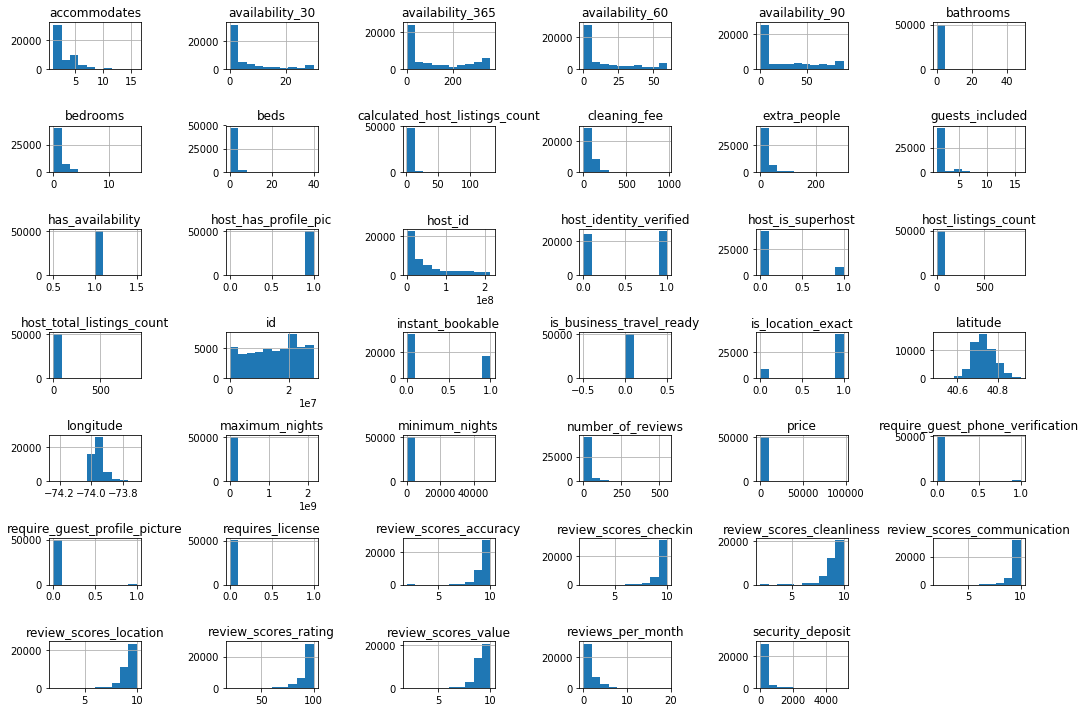

In [46]:
listings_df_new.hist(figsize=(15,10))
plt.tight_layout();

In [47]:
# Adjust listings_df_new to include only the top 99% of values for 'price' to remove outliers
listings_df_new = listings_df_new[listings_df_new['price'] < listings_df_new['price'].quantile(0.99)]

In [48]:
listings_df_new.shape

(49713, 71)

> **reviews_df - To Clean**
- **date** - change type to datetime
- **comments** - drop rows with missing comments

In [49]:
# Change 'date' type to datetime
reviews_df_new['date'] = pd.to_datetime(reviews_df_new['date'])

In [50]:
# Drop rows with missing comments
reviews_df_new = reviews_df_new.dropna()

In [51]:
reviews_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029027 entries, 0 to 1030207
Data columns (total 6 columns):
listing_id       1029027 non-null int64
id               1029027 non-null int64
date             1029027 non-null datetime64[ns]
reviewer_id      1029027 non-null int64
reviewer_name    1029027 non-null object
comments         1029027 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 55.0+ MB


## Exploratory Data Analysis

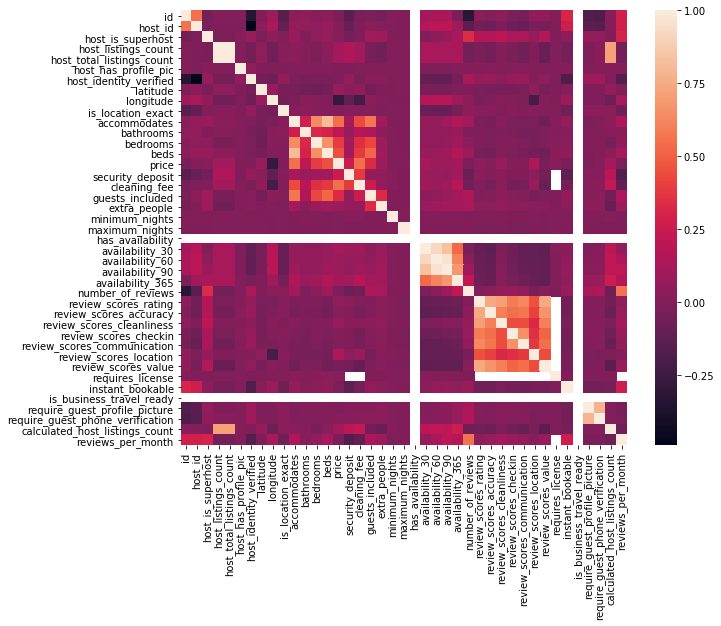

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(listings_df_new.corr(),xticklabels=True, yticklabels=True, ax=ax);

In [53]:
listings_df_new['review_scores_rating_grouped'] = pd.cut(x=listings_df_new['review_scores_rating'], bins=8,
                                                         labels=['20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']).values.add_categories('N/A')
listings_df_new['review_scores_rating_grouped'] = listings_df_new['review_scores_rating_grouped'].fillna('N/A')

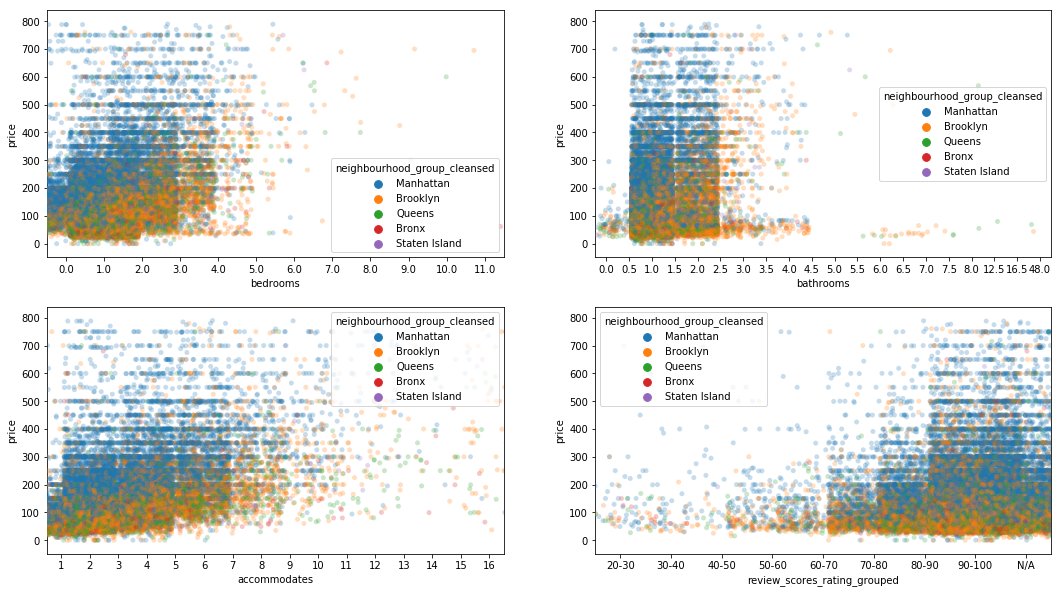

In [54]:
fig,axes = plt.subplots(2, 2,figsize=(18,10))
axes[0,0] = sns.stripplot(x='bedrooms', y='price', hue='neighbourhood_group_cleansed', 
                          data=listings_df_new, alpha=0.25, jitter=0.9, ax=axes[0,0])
axes[0,1] = sns.stripplot(x='bathrooms', y='price', hue='neighbourhood_group_cleansed', 
                          data=listings_df_new, alpha=0.25, jitter=0.9, ax=axes[0,1]);
axes[1,0] = sns.stripplot(x='accommodates', y='price', hue='neighbourhood_group_cleansed', 
                          data=listings_df_new, alpha=0.25, jitter=0.9, ax=axes[1,0]);
axes[1,1] = sns.stripplot(x='review_scores_rating_grouped', y='price', hue='neighbourhood_group_cleansed', 
                          data=listings_df_new, alpha=0.25, jitter=0.9, ax=axes[1,1]);

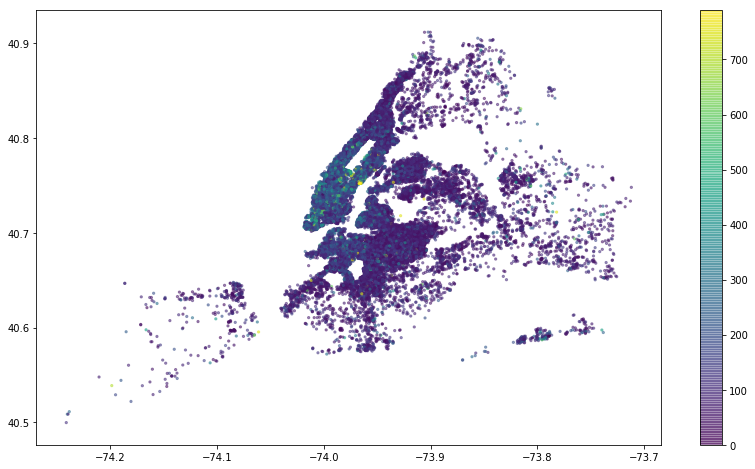

In [55]:
plt.subplots(figsize=(14,8))
plt.scatter(x=listings_df_new['longitude'],
            y=listings_df_new['latitude'],
            c=listings_df_new['price'],
            s=5,
            cmap='viridis',
            vmin=0, vmax=listings_df_new['price'].max(),
            alpha=.5)
plt.colorbar();